In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# 1. Load Data
data = load_breast_cancer()
X = data.data
y_true = data.target

# 2. Load Tools
%run metrics.ipynb  # Loads StandardScalerNumPy
%run GMM.ipynb      # Loads GMM

# Set Seeds
np.random.seed(42)
tf.random.set_seed(42)

GMM Class initialized.


In [11]:
# 3. Preprocessing (Using Custom Scaler)

class StandardScalerNumPy:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit_transform(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        # Add epsilon to avoid division by zero
        self.std[self.std == 0] = 1e-8
        return (X - self.mean) / self.std

    def inverse_transform(self, X_scaled):
        return (X_scaled * self.std) + self.mean

scaler = StandardScalerNumPy()
X_scaled = scaler.fit_transform(X)

print("Data standardized using StandardScalerNumPy.")

# 4. Define Autoencoder (Re-using structure from Exp 5)
BOTTLENECK_DIM = 2 

class Autoencoder(models.Model):
    def __init__(self, input_dim, bottleneck_dim=2, l2_reg=0.001):
        super(Autoencoder, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(bottleneck_dim, activation='linear', name='bottleneck') 
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(bottleneck_dim,)),
            layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(input_dim, activation='linear')
        ])

    def call(self, x):
        return self.decoder(self.encoder(x))
    
    def get_latent(self, x):
        return self.encoder.predict(x, verbose=0)

# Train
print(f"Training Autoencoder (Bottleneck={BOTTLENECK_DIM})...")
ae = Autoencoder(input_dim=X_scaled.shape[1], bottleneck_dim=BOTTLENECK_DIM)
ae.compile(optimizer='adam', loss='mse')
history = ae.fit(X_scaled, X_scaled, epochs=200, batch_size=32, shuffle=True, verbose=0)

# Extract Latent Features
X_latent = ae.get_latent(X_scaled)
print(f"Latent Representation Shape: {X_latent.shape}")

Data standardized using StandardScalerNumPy.
Training Autoencoder (Bottleneck=2)...


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Latent Representation Shape: (569, 2)


In [12]:
# --- Grid Search for GMM on Latent Data ---

covariance_types = ['full', 'tied', 'diagonal', 'spherical']
k_range = range(2, 11)

best_bic = np.inf
best_model_ae = None
best_config_ae = {}

print("Starting GMM Grid Search on Latent Data...")

for cov_type in covariance_types:
    for k in k_range:
        gmm = GMM(n_components=k, covariance_type=cov_type, max_iter=100, tol=1e-4)
        gmm.fit(X_latent)
        
        bic = gmm.bic(X_latent)
        
        if bic < best_bic:
            best_bic = bic
            best_model_ae = gmm
            best_config_ae = {'cov': cov_type, 'k': k}

print(f"Best AE-GMM: K={best_config_ae['k']}, Type={best_config_ae['cov']}, BIC={best_bic:.2f}")

Starting GMM Grid Search on Latent Data...
Best AE-GMM: K=6, Type=full, BIC=5482.98


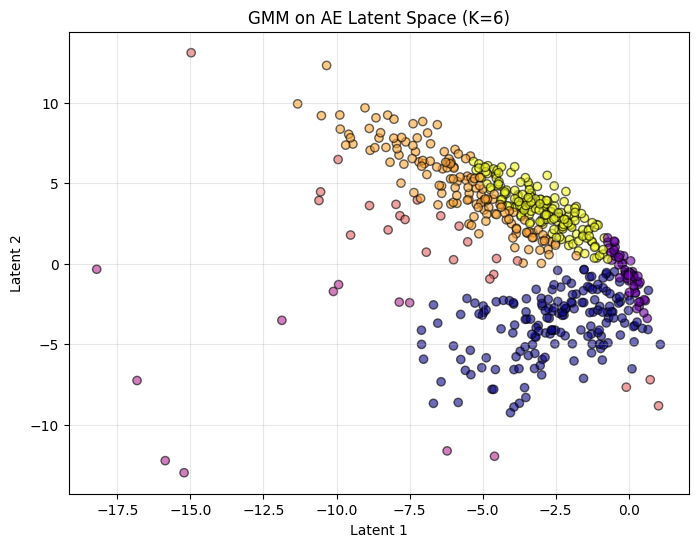

--- Validation Metrics (AE + GMM) ---
Silhouette Score: 0.2028
Purity:           0.9262
ARI:              0.3937


In [15]:
# --- Visualization & Evaluation ---

labels_ae = best_model_ae.predict(X_latent)

# Plot Latent Space
plt.figure(figsize=(8, 6))
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=labels_ae, cmap='plasma', edgecolor='k', alpha=0.6)
plt.title(f'GMM on AE Latent Space (K={best_config_ae["k"]})')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
plt.grid(True, alpha=0.3)
plt.show()

# Validation (Manual Metrics)
sil = silhouette_score_manual(X_latent, labels_ae)
purity = purity_score_manual(y_true, labels_ae)
ari = adjusted_rand_index_manual(y_true, labels_ae)





print("--- Validation Metrics (AE + GMM) ---")
print(f"Silhouette Score: {sil:.4f}")
print(f"Purity:           {purity:.4f}")
print(f"ARI:              {ari:.4f}")

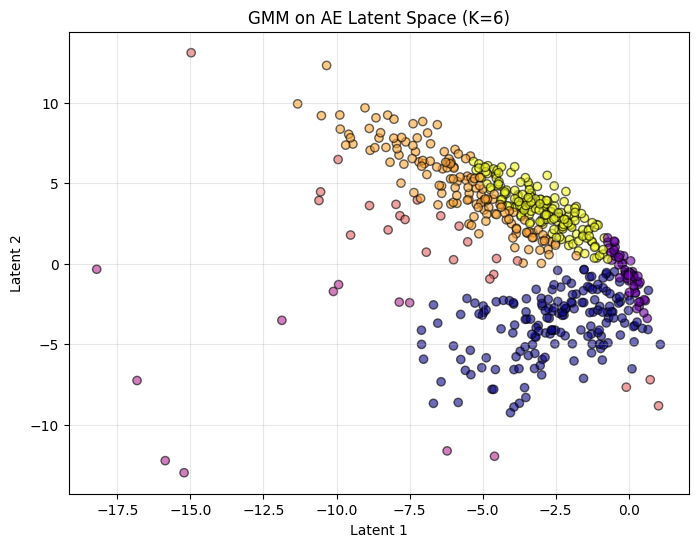

--- Validation Metrics (AE + GMM) ---
Silhouette Score: 0.2028
Purity:           0.9262
ARI:              0.3937


In [17]:
# --- Visualization & Evaluation ---

labels_ae = best_model_ae.predict(X_latent)

# Plot Latent Space
plt.figure(figsize=(8, 6))
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=labels_ae, cmap='plasma', edgecolor='k', alpha=0.6)
plt.title(f'GMM on AE Latent Space (K={best_config_ae["k"]})')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
plt.grid(True, alpha=0.3)
plt.show()

# Validation (Manual Metrics)
sil = silhouette_score_manual(X_latent, labels_ae)
purity = purity_score_manual(y_true, labels_ae)
ari = adjusted_rand_index_manual(y_true, labels_ae)


print("--- Validation Metrics (AE + GMM) ---")
print(f"Silhouette Score: {sil:.4f}")
print(f"Purity:           {purity:.4f}")
print(f"ARI:              {ari:.4f}")